# Calculate posterior

In [5]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../")
from simulation.prior import get_grid
from inference.bayes import Posterior

## Setup

In [6]:
n = 10
n_events_for_expectation = 100

In [14]:
filenames = [
    "alices_fix",
    "alices_mass_pre",
    "alices_align_pre",
    "alices_full_pre",
]
labels = ["Fix", "Mass", "Align", "Full"]

nmethods = len(filenames)
ncols = 2
nrows = (nmethods - 1) // ncols + 1

In [8]:
def prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * norm(-1.9, 0.1).pdf(beta).flatten()

## Load data

In [9]:
theta_grid = get_grid()

In [10]:
llrs = []
for filename in filenames:
    llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename))[:,:n_events_for_expectation])

## Param grid

In [18]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posteriors

In [11]:
posteriors = []

for llr in llrs:
    bayes = Posterior(llr, theta_grid)
    posteriors.append(
        bayes.posterior_based_on_expected_llr(n, prior)
    )

## Plot posteriors

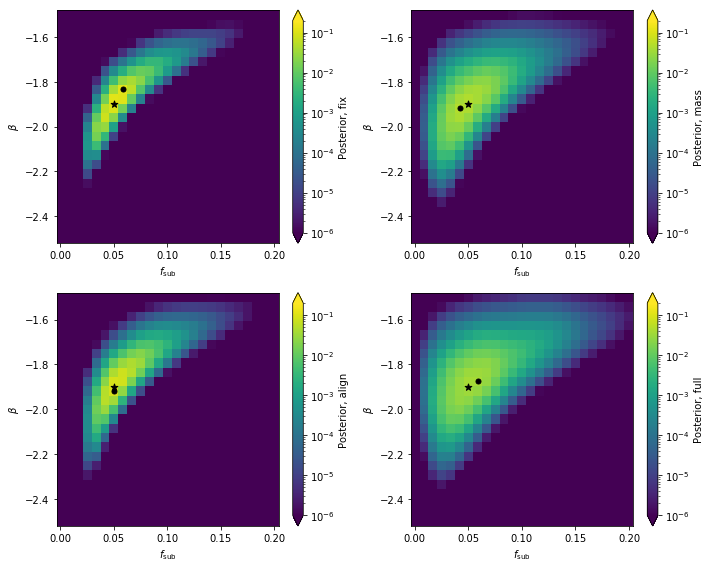

In [32]:
pmin, pmax = 1.e-6, 0.2
thresholds = [0.1]

fig = plt.figure(figsize=(5. * ncols, 4. * nrows))
ax_xs = []
ax_rs = []

for i, posterior in enumerate(posteriors):
    ax = plt.subplot(nrows, ncols, i + 1)

    i_mle = np.argmax(posteriors[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(posteriors[i], pmin, pmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    if False:
        cs = plt.contour(
            0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
            0.5 * (beta_edges[1:] + beta_edges[:-1]),
            z.reshape((resolution, resolution)),
            thresholds,
            colors="black",
            linewidths=1.,
            linestyles=["-" for _ in thresholds],
        )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'Posterior, '+ labels[i].lower())
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/posterior_2d.pdf")